In [1]:
import torch
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import joblib
import sys
import numpy as np
import json
import time
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, precision_score, roc_auc_score,
    top_k_accuracy_score
)


CLIP_FEATURES_DIR = "clip_features"
VAL = CLIP_FEATURES_DIR + "/val_features.pt"
SCALER = "scaler_model.joblib"
PCA = "pca_model.joblib"
LIME = "top_k_lime_indices.joblib"


MAX_EPOCHS = 500
EARLY_STOPPING = 25

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


In [2]:
def load_features(file_path):
    data = torch.load(file_path)
    return data["image_features"], data["text_features"], data["filenames"], data["labels"]


# Load train and validation features
val_img_features, val_txt_features, _, val_labels = load_features(VAL)

In [3]:
# Combine image and text features for training
X_val = torch.cat((val_img_features, val_txt_features), dim=1)

# Flatten features into a 2D matrix (samples x features)
X_val = X_val.view(X_val.size(0), -1).numpy()

# Print the shape of the features
print(f"X_val shape: {X_val.shape}")

# Convert labels to NumPy arrays
y_val = val_labels.numpy()  

# Load scaler and PCA models
scaler = joblib.load(SCALER)
pca = joblib.load(PCA)
lime = joblib.load(LIME)

# Scale and transform the features
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)
X_val_lime = X_val_scaled[:, lime]

X_val shape: (1985, 1024)


In [4]:
from classifiers import (
    SVMClassifier, RBFClassifier, RandomForestClassifier, NaiveBayesClassifier, 
    LogisticRegressionClassifier, LDAClassifier, KNNClassifier, DecisionTreeClassifier,
    AdaBoostClassifier, GBMClassifier, XGBoostClassifier
)

from ensembler import EnsemblerClassifier

# Instantiate classifiers
classifiers = [
    SVMClassifier(), RBFClassifier(), RandomForestClassifier(), NaiveBayesClassifier(),
    LogisticRegressionClassifier(), LDAClassifier(), KNNClassifier(),
    DecisionTreeClassifier(), AdaBoostClassifier(), GBMClassifier(),
    XGBoostClassifier()
]

for clf in classifiers:
    clf.load()

Loaded model from: models_pca/SVM.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/RBF.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/RandomForest.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/NaiveBayes.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/LogisticRegression.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/LDA.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/KNN.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/DecisionTree.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/AdaBoost.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/GBM.joblib
Loaded label e

In [5]:
from ensembler import WeightGeneratorNN, train_step

model = WeightGeneratorNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
train_history = []
best_score = -float("inf")

for epoch in range(MAX_EPOCHS):
    # ✅ Generate new input_params each epoch
    input_params = torch.rand(1, 7, device=DEVICE)  # Shape: (1, 7)
    
    print(f"Input params: {input_params}")
    score, loss = train_step(model, optimizer, input_params, X_val_pca, y_val, classifiers, device=DEVICE)
    train_history.append((score, loss))

    print(f"Epoch {epoch + 1}: Score={score:.4f}, Loss={loss:.4f}")

    # ✅ Check for convergence / early stopping
    if score > best_score:
        best_score = score
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_weight_generator.pt")  # Save best model
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= EARLY_STOPPING:
        print(f"Early stopping at epoch {epoch + 1}")
        break

Input params: tensor([[0.6130, 0.0101, 0.3984, 0.0403, 0.1563, 0.4825, 0.7362]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396777712755269), 0.10349055190368349]
Epoch 1: Score=0.2879, Loss=-0.2879
Input params: tensor([[0.9877, 0.1289, 0.5621, 0.5221, 0.7445, 0.5955, 0.9647]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8916876574307305), np.float64(0.9396369149965066), 0.10391620233976362]
Epoch 2: Score=0.2986, Loss=-0.2986
Input params: tensor([[0.8259, 0.2128, 0.7292, 0.3209, 0.7550, 0.2132, 0.9278]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396545935698295), 0.09831015820975411]
Epoch 3: Score=0.2750, Loss=-0.2750
Input params: tensor([[0.7296, 0.1194, 0.0511, 0.2384, 0.2015, 0.6364, 0.7799]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.8916876574307305), np.float64(0.939636038405623), 0.10717975660663945]
Epoch 4: Score=0.3053, Loss=-0.3053
Input params: tensor([[0.3264, 0.9967, 0.0706, 0.2893, 0.5037, 0.1414, 0.5756]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9396123183401071), 0.09500831590960902]
Epoch 5: Score=0.2656, Loss=-0.2656
Input params: tensor([[0.3148, 0.3071, 0.6121, 0.2254, 0.1048, 0.2307, 0.2066]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.892191435768262), np.float64(0.9397587637002666), 0.10360234876227879]
Epoch 6: Score=0.2657, Loss=-0.2657
Input params: tensor([[0.2255, 0.5835, 0.4364, 0.5677, 0.0702, 0.9806, 0.5637]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396685393517143), 0.10274370729993552]
Epoch 7: Score=0.3302, Loss=-0.3302
Input params: tensor([[0.3584, 0.2987, 0.3293, 0.3970, 0.6351, 0.4149, 0.2534]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8916876574307305), np.float64(0.939626380733497), 0.10275451058749198]
Epoch 8: Score=0.3352, Loss=-0.3352
Input params: tensor([[0.5480, 0.6785, 0.3931, 0.5995, 0.0826, 0.5502, 0.5010]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.939659870350145), 0.10278958406736743]
Epoch 9: Score=0.2658, Loss=-0.2658
Input params: tensor([[0.2663, 0.0755, 0.2934, 0.5025, 0.5348, 0.5001, 0.1181]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.939631408995008), 0.09275164590174027]
Epoch 10: Score=0.3473, Loss=-0.3473
Input params: tensor([[0.5246, 0.3515, 0.1484, 0.6268, 0.1380, 0.5421, 0.5927]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396636848957021), 0.10709495825616493]
Epoch 11: Score=0.2880, Loss=-0.2880
Input params: tensor([[0.3273, 0.5646, 0.2303, 0.2777, 0.2557, 0.8542, 0.6942]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9396442349381129), 0.09756716665944]
Epoch 12: Score=0.3312, Loss=-0.3312
Input params: tensor([[0.3806, 0.7871, 0.7982, 0.8877, 0.4213, 0.5568, 0.8711]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8916876574307305), np.float64(0.9396323885802033), 0.10651475387796452]
Epoch 13: Score=0.2593, Loss=-0.2593
Input params: tensor([[0.2197, 0.0624, 0.7493, 0.5316, 0.0191, 0.7160, 0.7776]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8926952141057934), np.float64(0.9396450031955069), 0.10684337494013103]
Epoch 14: Score=0.2926, Loss=-0.2926
Input params: tensor([[0.2590, 0.0092, 0.2037, 0.2077, 0.2052, 0.7141, 0.0142]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396538561137482), 0.10660594821125947]
Epoch 15: Score=0.3663, Loss=-0.3663
Input params: tensor([[0.7428, 0.8788, 0.0253, 0.1020, 0.0529, 0.9970, 0.8566]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.939677253137618), 0.10577854503557044]
Epoch 16: Score=0.3077, Loss=-0.3077
Input params: tensor([[0.9205, 0.0521, 0.2885, 0.7266, 0.0763, 0.6723, 0.9147]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9396456924792748), 0.09490643919312927]
Epoch 17: Score=0.2682, Loss=-0.2682
Input params: tensor([[0.0967, 0.6952, 0.3411, 0.2648, 0.9526, 0.6189, 0.5905]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9395861507522004), 0.1068858689207876]
Epoch 18: Score=0.3694, Loss=-0.3694
Input params: tensor([[0.6813, 0.7757, 0.1968, 0.1273, 0.3428, 0.0888, 0.2174]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.939715636929951), 0.0964709398447464]
Epoch 19: Score=0.2535, Loss=-0.2535
Input params: tensor([[0.3281, 0.5572, 0.7329, 0.6278, 0.9680, 0.6967, 0.5365]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9396536031019185), 0.10091016585888248]
Epoch 20: Score=0.3496, Loss=-0.3496
Input params: tensor([[0.3400, 0.7018, 0.9824, 0.6102, 0.6480, 0.1562, 0.1762]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.892191435768262), np.float64(0.9397544098792103), 0.0992617533940255]
Epoch 21: Score=0.2634, Loss=-0.2634
Input params: tensor([[0.3767, 0.8700, 0.2904, 0.6275, 0.9200, 0.0908, 0.4267]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.891183879093199), np.float64(0.939616508232467), 0.102541615578859]
Epoch 22: Score=0.3044, Loss=-0.3044
Input params: tensor([[0.9150, 0.7407, 0.0909, 0.8886, 0.2168, 0.2315, 0.9002]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.892191435768262), np.float64(0.9396356895791317), 0.10221273807883516]
Epoch 23: Score=0.2225, Loss=-0.2225
Input params: tensor([[0.2950, 0.5336, 0.9235, 0.8606, 0.6720, 0.9851, 0.8246]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008832854842022005, 0.131607859861911, np.float64(0.8916876574307305), np.float64(0.9396536391232411), 0.0951147985745425]
Epoch 24: Score=0.3258, Loss=-0.3258
Input params: tensor([[0.2217, 0.0622, 0.4805, 0.8663, 0.0489, 0.3967, 0.2863]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.8926952141057934), np.float64(0.939704347728713), 0.10855439270496957]
Epoch 25: Score=0.2776, Loss=-0.2776
Input params: tensor([[0.7364, 0.1495, 0.3245, 0.2529, 0.7070, 0.6776, 0.7060]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.8916876574307305), np.float64(0.9396239833512283), 0.09590080085312144]
Epoch 26: Score=0.3400, Loss=-0.3400
Input params: tensor([[0.1350, 0.8323, 0.0010, 0.5299, 0.8164, 0.3631, 0.8653]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9395586367585353), 0.10502166221517098]
Epoch 27: Score=0.3174, Loss=-0.3174
Input params: tensor([[0.6967, 0.1732, 0.2300, 0.4392, 0.6209, 0.6046, 0.9395]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9395995410788948), 0.10751244236876678]
Epoch 28: Score=0.3178, Loss=-0.3178
Input params: tensor([[0.4421, 0.5961, 0.8537, 0.3632, 0.1425, 0.7827, 0.2804]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8926952141057934), np.float64(0.9397251875372873), 0.1035962099576504]
Epoch 29: Score=0.2926, Loss=-0.2926
Input params: tensor([[0.1435, 0.9331, 0.3964, 0.8893, 0.1951, 0.8708, 0.1179]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.939625923823751), 0.10575730115632966]
Epoch 30: Score=0.3087, Loss=-0.3087
Input params: tensor([[0.5209, 0.2273, 0.0363, 0.0263, 0.6192, 0.4060, 0.2164]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9396167933255444), 0.09954258111817897]
Epoch 31: Score=0.3497, Loss=-0.3497
Input params: tensor([[0.4460, 0.5688, 0.9520, 0.3400, 0.2106, 0.9363, 0.3674]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9397118058002418), 0.10680513013506304]
Epoch 32: Score=0.3096, Loss=-0.3096
Input params: tensor([[0.6288, 0.4497, 0.7395, 0.6017, 0.1088, 0.2634, 0.3006]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.892191435768262), np.float64(0.9397409459131719), 0.10036579172018303]
Epoch 33: Score=0.2372, Loss=-0.2372
Input params: tensor([[0.4141, 0.1592, 0.2009, 0.2850, 0.8516, 0.4949, 0.3461]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9395963192885273), 0.10773277499231426]
Epoch 34: Score=0.3752, Loss=-0.3752
Input params: tensor([[0.5776, 0.2870, 0.2092, 0.2488, 0.8796, 0.2365, 0.1927]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.939615833324682), 0.10495241401081737]
Epoch 35: Score=0.3490, Loss=-0.3490
Input params: tensor([[0.5251, 0.7096, 0.8265, 0.4151, 0.0898, 0.2526, 0.2817]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.892191435768262), np.float64(0.9397418008267073), 0.10408757572790135]
Epoch 36: Score=0.2291, Loss=-0.2291
Input params: tensor([[0.6672, 0.7297, 0.7153, 0.0852, 0.8851, 0.1214, 0.7390]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9396852113278547), 0.10276251131708349]
Epoch 37: Score=0.2836, Loss=-0.2836
Input params: tensor([[0.1688, 0.4637, 0.4261, 0.3507, 0.7219, 0.6644, 0.9331]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8916876574307305), np.float64(0.9395666705211673), 0.09572847110550588]
Epoch 38: Score=0.3364, Loss=-0.3364
Input params: tensor([[0.6792, 0.5939, 0.6711, 0.8107, 0.5413, 0.5394, 0.5129]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396604385802015), 0.10308360081146523]
Epoch 39: Score=0.2796, Loss=-0.2796
Input params: tensor([[0.2778, 0.9270, 0.4700, 0.5651, 0.6830, 0.0246, 0.9947]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.892191435768262), np.float64(0.9396201692414565), 0.09436603177074451]
Epoch 40: Score=0.2525, Loss=-0.2525
Input params: tensor([[0.2276, 0.0867, 0.5657, 0.1369, 0.7884, 0.7628, 0.7929]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9395948470456803), 0.10267132451610343]
Epoch 41: Score=0.3718, Loss=-0.3718
Input params: tensor([[0.0360, 0.0208, 0.9682, 0.5549, 0.2319, 0.1258, 0.8626]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396380720687706), 0.1060178755325091]
Epoch 42: Score=0.2421, Loss=-0.2421
Input params: tensor([[0.1739, 0.1845, 0.4298, 0.6736, 0.7397, 0.8306, 0.4428]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.939613419690127), 0.10637180530785241]
Epoch 43: Score=0.3786, Loss=-0.3786
Input params: tensor([[0.6440, 0.8300, 0.5889, 0.7381, 0.8584, 0.3994, 0.5944]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.891183879093199), np.float64(0.9396457498635281), 0.10179332569590863]
Epoch 44: Score=0.2918, Loss=-0.2918
Input params: tensor([[0.7353, 0.2134, 0.2576, 0.4983, 0.6941, 0.7496, 0.3292]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9396534292968958), 0.09638709044344385]
Epoch 45: Score=0.3537, Loss=-0.3537
Input params: tensor([[0.3857, 0.1594, 0.9100, 0.9670, 0.3187, 0.7205, 0.0048]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.8926952141057934), np.float64(0.9397567131881545), 0.10274463852835268]
Epoch 46: Score=0.2995, Loss=-0.2995
Input params: tensor([[0.3011, 0.3871, 0.1026, 0.5657, 0.1310, 0.0965, 0.2504]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396660281448219), 0.09775604377102337]
Epoch 47: Score=0.2649, Loss=-0.2649
Input params: tensor([[0.0803, 0.1646, 0.4607, 0.6484, 0.4402, 0.5509, 0.9936]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008769351279645317, 0.13149694466238934, np.float64(0.892191435768262), np.float64(0.9395758807884684), 0.10375959264472517]
Epoch 48: Score=0.3047, Loss=-0.3047
Input params: tensor([[0.9880, 0.4217, 0.4710, 0.1448, 0.4388, 0.5274, 0.4100]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9397422633769024), 0.10525752068697412]
Epoch 49: Score=0.2845, Loss=-0.2845
Input params: tensor([[0.5724, 0.0756, 0.9631, 0.4070, 0.1425, 0.6308, 0.6536]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00883624728873939, 0.131610404196949, np.float64(0.892191435768262), np.float64(0.9397000317485448), 0.10732101436748699]
Epoch 50: Score=0.2720, Loss=-0.2720
Input params: tensor([[0.8908, 0.6937, 0.1413, 0.5308, 0.2705, 0.7169, 0.5220]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.892191435768262), np.float64(0.9396817874577789), 0.10506377189277379]
Epoch 51: Score=0.2871, Loss=-0.2871
Input params: tensor([[0.7894, 0.1502, 0.6730, 0.8069, 0.7915, 0.5644, 0.2631]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8916876574307305), np.float64(0.9396891774450912), 0.09688937202242413]
Epoch 52: Score=0.3184, Loss=-0.3184
Input params: tensor([[0.5687, 0.4675, 0.6359, 0.5178, 0.0412, 0.3068, 0.4828]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396993137910213), 0.10299191434561841]
Epoch 53: Score=0.2409, Loss=-0.2409
Input params: tensor([[0.0330, 0.4013, 0.0487, 0.2754, 0.5370, 0.0585, 0.7074]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9395681751241058), 0.09505990402319928]
Epoch 54: Score=0.3010, Loss=-0.3010
Input params: tensor([[0.7290, 0.4022, 0.1133, 0.0935, 0.5541, 0.2794, 0.6259]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9396397764963399), 0.10378231917470482]
Epoch 55: Score=0.2959, Loss=-0.2959
Input params: tensor([[0.7934, 0.7336, 0.0933, 0.5329, 0.1292, 0.7459, 0.7644]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.892191435768262), np.float64(0.93966790832489), 0.10354490941094277]
Epoch 56: Score=0.2792, Loss=-0.2792
Input params: tensor([[0.7452, 0.1849, 0.7450, 0.0198, 0.4893, 0.0075, 0.6316]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9397372821010715), 0.10669123829788273]
Epoch 57: Score=0.2540, Loss=-0.2540
Input params: tensor([[0.4588, 0.4055, 0.1691, 0.5202, 0.7215, 0.2336, 0.8998]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9395895582078576), 0.10405703718442165]
Epoch 58: Score=0.3014, Loss=-0.3014
Input params: tensor([[0.7546, 0.5605, 0.6242, 0.7234, 0.6477, 0.6232, 0.2995]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.8916876574307305), np.float64(0.9396719969965086), 0.09664716927156151]
Epoch 59: Score=0.3020, Loss=-0.3020
Input params: tensor([[0.1017, 0.3158, 0.7220, 0.7116, 0.5762, 0.0150, 0.0801]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.892191435768262), np.float64(0.9397280707385505), 0.10437078335519635]
Epoch 60: Score=0.2833, Loss=-0.2833
Input params: tensor([[0.5061, 0.7827, 0.1248, 0.9541, 0.9498, 0.9325, 0.7105]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008769351279645317, 0.13149694466238934, np.float64(0.892191435768262), np.float64(0.9395799668340408), 0.09560536019535268]
Epoch 61: Score=0.3577, Loss=-0.3577
Input params: tensor([[0.7183, 0.5454, 0.9365, 0.9898, 0.2676, 0.7585, 0.0518]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008827611088667423, 0.13159737544684044, np.float64(0.892191435768262), np.float64(0.939737887249766), 0.1032401418594944]
Epoch 62: Score=0.2729, Loss=-0.2729
Input params: tensor([[0.7740, 0.3599, 0.1221, 0.5076, 0.2657, 0.3773, 0.7452]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.892191435768262), np.float64(0.9396455143346433), 0.10594514545853229]
Epoch 63: Score=0.2677, Loss=-0.2677
Input params: tensor([[0.4574, 0.6555, 0.1410, 0.7977, 0.3613, 0.9201, 0.7842]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008817790848169733, 0.13159006725045458, np.float64(0.892191435768262), np.float64(0.9396431057479067), 0.10581513971694811]
Epoch 64: Score=0.3228, Loss=-0.3228
Input params: tensor([[0.8325, 0.1641, 0.9071, 0.5715, 0.2167, 0.4434, 0.7731]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.008824218641950038, 0.13159483111180242, np.float64(0.892191435768262), np.float64(0.9396946403912784), 0.10397337661392776]
Epoch 65: Score=0.2427, Loss=-0.2427
Input params: tensor([[0.9913, 0.8589, 0.1130, 0.5497, 0.2033, 0.1782, 0.3875]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9397029931716474), 0.09746010513217365]
Epoch 66: Score=0.2235, Loss=-0.2235
Input params: tensor([[0.7304, 0.6202, 0.7083, 0.7617, 0.8910, 0.5233, 0.5531]],
       device='cuda:0')


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.8916876574307305), np.float64(0.9396542196668747), 0.10292038870267309]
Epoch 67: Score=0.3056, Loss=-0.3056
Input params: tensor([[0.7293, 0.7167, 0.6847, 0.3165, 0.6475, 0.5711, 0.5161]],
       device='cuda:0')
Metrics: [0.008060453400503778, 0.008060453400503778, 0.00882094735404399, 0.1315923974000269, np.float64(0.892191435768262), np.float64(0.9397000576434157), 0.09604215913137652]
Epoch 68: Score=0.2930, Loss=-0.2930
Early stopping at epoch 68


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

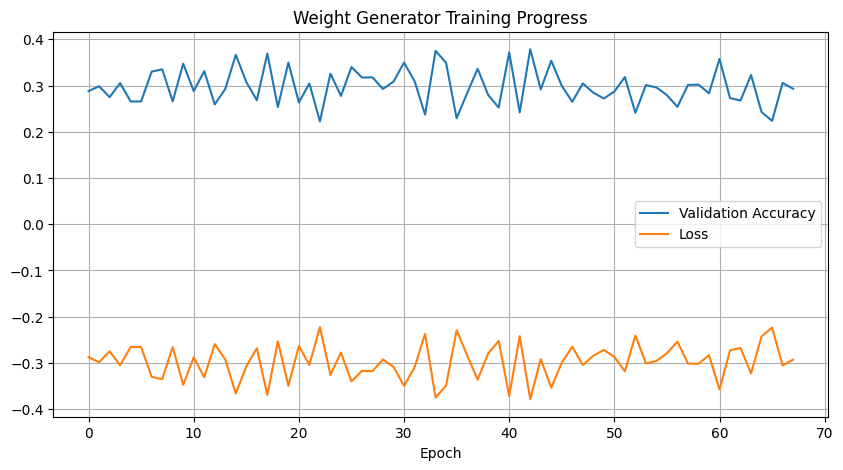

In [7]:
scores, losses = zip(*train_history)
plt.figure(figsize=(10, 5))
plt.plot(scores, label="Validation Accuracy")
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Weight Generator Training Progress")
plt.grid()
plt.show()